# Requirements

In [1]:
# !pip install --upgrade transformers bertviz checklist

# Data loading

In [2]:
# !rm -rf ru_news_cause_v1.tsv*
# !wget https://www.dropbox.com/s/kcxnhjzfut4guut/ru_news_cause_v1.tsv.tar.gz
# !tar -xzvf ru_news_cause_v1.tsv.tar.gz

In [3]:
# !cat ru_news_cause_v1.tsv | wc -l
# !head ru_news_cause_v1.tsv

# First we need a trained BertCause model

## Training

In [1]:
import csv

records = []
with open("ru_news_cause_v1.tsv", "r", encoding='utf-8') as r:
    reader = csv.reader(r, delimiter="\t")
    header = next(reader)
    for row in reader:
        r = dict(zip(header, row))
        if float(r["confidence"]) < 0.69:
            continue
        result = r["result"]
        mapping = {
            "bad": 0,
            "rel": 0,
            "same": 0,
            "left_right_cause": 1,
            "left_right_cancel": 1,
            "right_left_cause": 2,
            "right_left_cancel": 2
        }
        if result not in mapping:
            continue
        r["label"] = mapping[result]
        records.append(r)

In [2]:
from collections import Counter

labels_counter = Counter([r["label"] for r in records])
labels_count = len(labels_counter)
labels_counter

Counter({0: 1957, 2: 763, 1: 706})

In [3]:
import json
import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer

class NewsPairsDataset(Dataset):
    def __init__(self, records, max_tokens, model_name, labels_count):
        self.tokenizer = AutoTokenizer.from_pretrained(
            model_name,
            do_lower_case=False
        )
        self.max_tokens = max_tokens
        self.records = records
        self.labels_count = labels_count
    
    def __len__(self):
        return len(self.records)
    
    def embed_record(self, record):
        inputs = self.tokenizer(
            text=record["left_title"],
            text_pair=record["right_title"],
            add_special_tokens=True,
            max_length=self.max_tokens,
            padding="max_length",
            truncation="longest_first",
            return_tensors='pt'
        )
        for key, value in inputs.items():
            value.squeeze_(0)
        return inputs
    
    def __getitem__(self, index):
        record = self.records[index]
        output = self.embed_record(record)
        label = record.get("label", None)
        if label is not None:
            output["labels"] = torch.tensor(label)
        return output

In [4]:
import random
from collections import defaultdict

records_by_source = defaultdict(list)
for r in records:
    source = r["id"].split("_")[0]
    records_by_source[source].append(r)

train_records, val_records, test_records = [], [], []
for _, source_records in records_by_source.items():
    source_records.sort(key=lambda x: min(x["left_timestamp"], x["right_timestamp"]))
    val_border = int(0.8 * len(source_records))
    test_border = int(0.9 * len(source_records))
    train_records.extend(source_records[:val_border])
    val_records.extend(source_records[val_border:test_border])
    test_records.extend(source_records[test_border:])

print(len(train_records))
print(len(val_records))
print(len(test_records))

2740
343
343


In [5]:
MODEL_NAME = "DeepPavlov/rubert-base-cased"
TOKENIZER_NAME = MODEL_NAME
MAX_TOKENS = 80

In [6]:
from torch.utils.data import DataLoader, RandomSampler

train_data = NewsPairsDataset(train_records, MAX_TOKENS, TOKENIZER_NAME, labels_count)
val_data = NewsPairsDataset(val_records, MAX_TOKENS, TOKENIZER_NAME, labels_count)

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/642 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [7]:
for item in train_data:
    print(item)
    break

{'input_ids': tensor([  101, 35278, 10706, 11346,  1469,  9495,  3468, 60663,   851, 14245,
          869, 49010,   102,   815, 19843, 17514, 22415, 47023,  9551, 11031,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [8]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=labels_count, cache_dir="~/Volume/_transformers_cache/")
model = model.to("cuda")

2021-08-03 17:54:31.647064: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Downloading:   0%|          | 0.00/642 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/711M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
!rm -rf checkpoints

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [10]:
from transformers import Trainer, TrainingArguments

EPOCHS = 6
EVAL_STEPS = 10 #*8
WARMUP_STEPS = 5 # *8
LR = 3e-05
BATCH_SIZE = 128//8 # 
GRAD_ACCUM_STEPS = 1*8

training_args = TrainingArguments(
    output_dir="checkpoints",
    evaluation_strategy="steps",
    save_strategy="steps",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    logging_steps=EVAL_STEPS,
    save_steps=EVAL_STEPS,
    warmup_steps=WARMUP_STEPS,
    learning_rate=LR,
    num_train_epochs=EPOCHS,
    gradient_accumulation_steps=GRAD_ACCUM_STEPS,
    report_to="none",
#     report_to="wandb",  # enable logging to W&B
    run_name="newscausation_basetask",
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data
)

trainer.train()

***** Running training *****
  Num examples = 2740
  Num Epochs = 6
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 8
  Total optimization steps = 126


Step,Training Loss,Validation Loss
10,1.023900,0.970942
20,0.974900,0.915400
30,0.963900,0.832996
40,0.836100,0.786124
50,0.781800,0.731016
60,0.695100,0.700928
70,0.685800,0.641406
80,0.557300,0.578262
90,0.489600,0.524932
100,0.399400,0.510130


***** Running Evaluation *****
  Num examples = 343
  Batch size = 16
Saving model checkpoint to checkpoints/checkpoint-10
Configuration saved in checkpoints/checkpoint-10/config.json
Model weights saved in checkpoints/checkpoint-10/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 343
  Batch size = 16
Saving model checkpoint to checkpoints/checkpoint-20
Configuration saved in checkpoints/checkpoint-20/config.json
Model weights saved in checkpoints/checkpoint-20/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 343
  Batch size = 16
Saving model checkpoint to checkpoints/checkpoint-30
Configuration saved in checkpoints/checkpoint-30/config.json
Model weights saved in checkpoints/checkpoint-30/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 343
  Batch size = 16
Saving model checkpoint to checkpoints/checkpoint-40
Configuration saved in checkpoints/checkpoint-40/config.json
Model weights saved in checkpoints/checkpoint-40/pytorch_model.

TrainOutput(global_step=126, training_loss=0.6628480998296586, metrics={'train_runtime': 300.8024, 'train_samples_per_second': 54.654, 'train_steps_per_second': 0.419, 'total_flos': 1399055991281280.0, 'train_loss': 0.6628480998296586, 'epoch': 5.98})

## Inference

In [11]:
import numpy as np

test_data = NewsPairsDataset(test_records, MAX_TOKENS, TOKENIZER_NAME, labels_count)
y_true = [item["labels"].item() for item in test_data]
y_true = np.array(y_true, dtype=np.int32)
print(y_true)

loading configuration file https://huggingface.co/DeepPavlov/rubert-base-cased/resolve/main/config.json from cache at /home/altsoph/.cache/huggingface/transformers/a43261a78bd9edbbf43584c6b00aa94c032301840e532839cb5989362562a5d5.e8f15c5aad2f4653e46ceeba0bb32c02a629d106a902c964bce60523d290ac8f
Model config BertConfig {
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transforme

[0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 2 0 0 0 0 0 1 2 0 1 1
 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 1 2 1 2 2 2 0 1 0 0 0 0 0 0 1 1 1 0
 0 1 0 1 0 1 0 0 0 2 2 0 0 0 0 0 1 0 2 0 0 1 1 1 0 1 2 0 1 0 1 1 2 0 1 1 0
 2 2 1 1 1 2 1 1 0 1 0 1 0 0 2 0 2 1 2 0 1 2 2 2 0 0 2 2 2 0 0 0 2 1 0 0 2
 2 0 1 0 0 2 0 1 0 1 0 0 0 1 1 0 0 0 0 2 0 1 2 0 2 2 0 1 2 1 1 1 1 0 1 0 1
 0 0 0 1 0 1 0 1 0 0 2 1 1 0 2 0 1 2 2 2 0 0 0 0 2 0 2 0 0 0 0 0 0 0 0 1 1
 2 1 0 2 0 2 1 0 2 2 0 0 0 1 0 0 0 1 1 0 2 1 1 1 1 2 1 1 1 1 1 0 1 1 2 0 0
 1 0 2 1 1 2 0 1 0 0 1 2 1 1 0 1 1 2 2 0 0 0 1 2 2 1 2 0 0 1 1 0 1 2 0 1 1
 2 2 1 0 1 0 2 0 0 1]


In [12]:
y_pred = []
with torch.no_grad():
    for item in test_data:
        for key, value in item.items():
            item[key] = value.unsqueeze_(0).cuda()
        outputs = model(**item, return_dict=True)
        pred = torch.argmax(outputs.logits).item()
        y_pred.append(pred)
y_pred = np.array(y_pred)
print(y_pred)

[0 0 0 0 0 0 2 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 2 1 0 1 1 2 0 0 0 1 2 0 0 0 0 0 1 1 0 1 0
 2 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 1 1 0 1 2 2 2 2 1 0 0 0 0 0 0 1 1 1 0
 0 1 0 1 2 0 1 1 0 2 0 0 0 0 0 2 1 0 2 0 0 1 1 0 0 1 2 0 0 0 1 1 0 0 1 0 0
 0 2 1 1 1 0 0 1 1 0 0 0 2 0 2 0 2 0 2 0 0 2 2 2 0 0 2 2 2 0 0 0 2 1 0 0 0
 2 0 1 1 0 2 0 0 0 1 0 0 0 1 0 0 0 0 0 2 0 1 2 0 2 2 0 0 2 0 1 0 1 0 1 0 2
 0 0 0 1 0 1 0 1 0 0 2 0 1 0 2 0 1 2 2 2 0 0 0 2 2 0 2 0 0 0 0 0 0 0 0 1 1
 2 0 0 0 2 2 1 2 2 0 0 0 2 1 0 0 0 1 2 0 0 0 1 2 1 0 1 0 0 1 0 0 2 1 2 0 0
 1 0 2 1 1 2 0 0 1 0 1 2 1 1 0 1 1 2 2 0 0 0 1 2 2 1 0 0 0 1 1 0 1 2 0 1 0
 0 2 1 0 0 0 0 0 2 1]


In [13]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       186
           1       0.88      0.68      0.76        96
           2       0.72      0.75      0.74        61

    accuracy                           0.80       343
   macro avg       0.80      0.77      0.78       343
weighted avg       0.81      0.80      0.80       343



In [15]:
new_titles = []
with open("titles.txt", "r", encoding='utf-8') as r:
    for line in r:
        new_titles.append( line.strip() )
print(len(new_titles))

118372


In [34]:
import numpy as np

np.random.seed(1337)
np.random.shuffle(new_titles)

SAMPLE_SIZE = 500

sample = new_titles[:SAMPLE_SIZE]


new_records = []
for idx1, t1 in enumerate(sample):
    for idx2, t2 in enumerate(sample):
        if idx2>idx1:
            record = dict()
            record["left_title"] = t1
            record["right_title"] = t2
            record['label'] = 0
            new_records.append(record)
print(len(new_records))

124750


In [35]:
new_data = NewsPairsDataset(new_records, MAX_TOKENS, TOKENIZER_NAME, labels_count)
y_pred = []
with torch.no_grad():
    for item in new_data:
        for key, value in item.items():
            item[key] = value.unsqueeze_(0).cuda()
        outputs = model(**item, return_dict=True)
        pred = torch.argmax(outputs.logits).item()
        y_pred.append(pred)
y_pred = np.array(y_pred)
print(y_pred)


loading configuration file https://huggingface.co/DeepPavlov/rubert-base-cased/resolve/main/config.json from cache at /home/altsoph/.cache/huggingface/transformers/a43261a78bd9edbbf43584c6b00aa94c032301840e532839cb5989362562a5d5.e8f15c5aad2f4653e46ceeba0bb32c02a629d106a902c964bce60523d290ac8f
Model config BertConfig {
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transforme

[0 0 0 ... 0 0 0]


In [36]:
import networkx as nx
G = nx.DiGraph()

for item, label in zip(new_records, y_pred):
    if label==1:
        print(f'{label}\t{item["left_title"]}\t{item["right_title"]}')
        G.add_edge(item["left_title"], item["right_title"])
    elif label==2:
        print(f'{label}\t{item["right_title"]}\t{item["left_title"]}')
        G.add_edge(item["right_title"], item["left_title"])
        

2	Губернатор Пензенской области заразился коронавирусом	Россиянам рассказали о влиянии коронавируса на вождение
1	Найдена самая большая квартира Москвы	Вучич отреагировал на пост Захаровой о стульях в Белом доме
2	Пассажир самолета вынуждал попутчиков признать Иисуса черным и грозил их убить	Путин прокомментировал борьбу чернокожих за свои права
2	Ариана Гранде, Тимоти Шаламе и другие звезды вышли на улицы во время беспорядков	Путин прокомментировал борьбу чернокожих за свои права
2	Умерла народная артистка России Алла Йошпе	Путин прокомментировал борьбу чернокожих за свои права
2	Неизвестные с оружием начали обыскивать минский офис Uber	Вучич отреагировал на пост Захаровой о стульях в Белом доме
2	Девушка потратила сто миллионов рублей на внешность Ким Кардашьян и прославилась	Вучич отреагировал на пост Захаровой о стульях в Белом доме
2	Чулки жен политиков обсудили в сети после выхода Джилл Байден в сетчатых чулках	Вучич отреагировал на пост Захаровой о стульях в Белом доме
2	Борис Д

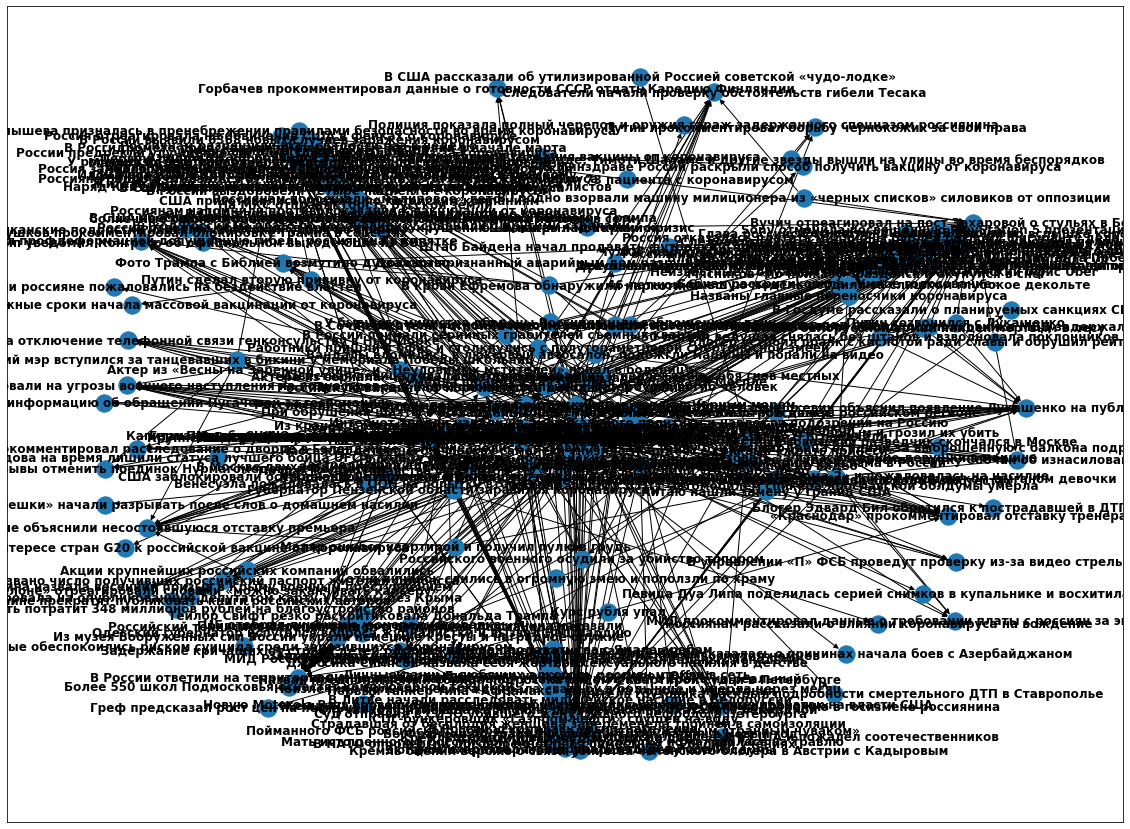

In [37]:
import matplotlib.pyplot as plt

# subax1 = plt.subplot(111)
plt.figure(figsize=(20,15))
pos = nx.spring_layout(G)
nx.draw_networkx(G,pos, with_labels=True, font_weight='bold')



# Something went wrong
### Hypothesis: some titles like 'refutes' are easy to guess without checking the other news in pair, so BERT always vote for causation/cancelation in favor of them
### Let's check it by making a single title classifier

In [62]:
singles = []
singles_types_mask = []
singles2type = dict()
with open("ru_news_cause_v1.tsv", "r", encoding='utf-8') as r:
    reader = csv.reader(r, delimiter="\t")
    header = next(reader)
    for row in reader:
        r = dict(zip(header, row))
        if float(r["confidence"]) < 0.69:
            continue
        result = r["result"]
        if result == 'left_right_cause':
            singles.append( {'id':r['id']+'_l', 'title':r['left_title'], 'timestamp':r['left_timestamp'], 'label':0 } )
            singles_types_mask.append( 0 ) # 0 for cause
            singles.append( {'id':r['id']+'_r', 'title':r['right_title'], 'timestamp':r['right_timestamp'], 'label':1 } )
            singles_types_mask.append( 0 ) # 0 for cause
            singles2type[r['left_title']] = 0
            singles2type[r['right_title']] = 0
        elif result == 'left_right_cancel':
            singles.append( {'id':r['id']+'_l', 'title':r['left_title'], 'timestamp':r['left_timestamp'], 'label':0 } )
            singles_types_mask.append( 1 ) # 1 for cancel
            singles.append( {'id':r['id']+'_r', 'title':r['right_title'], 'timestamp':r['right_timestamp'], 'label':1 } )
            singles_types_mask.append( 1 ) # 1 for cancel
            singles2type[r['left_title']] = 1
            singles2type[r['right_title']] = 1
        elif result == 'right_left_cause':
            singles.append( {'id':r['id']+'_l', 'title':r['left_title'], 'timestamp':r['left_timestamp'], 'label':1 } )
            singles_types_mask.append( 0 ) # 0 for cause
            singles.append( {'id':r['id']+'_r', 'title':r['right_title'], 'timestamp':r['right_timestamp'], 'label':0 } )
            singles_types_mask.append( 0 ) # 0 for cause
            singles2type[r['left_title']] = 0
            singles2type[r['right_title']] = 0
        elif result == 'right_left_cancel':
            singles.append( {'id':r['id']+'_l', 'title':r['left_title'], 'timestamp':r['left_timestamp'], 'label':1 } )
            singles_types_mask.append( 1 ) # 1 for cancel
            singles.append( {'id':r['id']+'_r', 'title':r['right_title'], 'timestamp':r['right_timestamp'], 'label':0 } )
            singles_types_mask.append( 1 ) # 0 for cancel
            singles2type[r['left_title']] = 1
            singles2type[r['right_title']] = 1
print(len(singles))
singles_types_mask = np.array(singles_types_mask)
singles_types_mask

2938


array([1, 1, 0, ..., 1, 0, 0])

In [47]:
class NewsSinglesDataset(Dataset):
    def __init__(self, records, max_tokens, model_name, labels_count):
        self.tokenizer = AutoTokenizer.from_pretrained(
            model_name,
            do_lower_case=False
        )
        self.max_tokens = max_tokens
        self.records = records
        self.labels_count = labels_count
    
    def __len__(self):
        return len(self.records)
    
    def embed_record(self, record):
        inputs = self.tokenizer(
            text=record["title"],
            add_special_tokens=True,
            max_length=self.max_tokens,
            padding="max_length",
            truncation="longest_first",
            return_tensors='pt'
        )
        for key, value in inputs.items():
            value.squeeze_(0)
        return inputs
    
    def __getitem__(self, index):
        record = self.records[index]
        output = self.embed_record(record)
        label = record.get("label", None)
        if label is not None:
            output["labels"] = torch.tensor(label)
        return output

In [66]:
single_records_by_source = defaultdict(list)
for r in singles:
    source = r["id"].split("_",1)[0]
    single_records_by_source[source].append(r)

singles_train_records, singles_val_records, singles_test_records = [], [], []
test_mask = []
for _, source_records in single_records_by_source.items():
    source_records.sort(key=lambda x: x["timestamp"])
    val_border = int(0.8 * len(source_records))
    test_border = int(0.9 * len(source_records))
    singles_train_records.extend(source_records[:val_border])
    singles_val_records.extend(source_records[val_border:test_border])
    singles_test_records.extend(source_records[test_border:])
    for t in source_records[test_border:]:
        test_mask.append( singles2type[t['title']] )
#     test_mask = singles_types_mask[test_border:]

print(len(singles_train_records))
print(len(singles_val_records))
print(len(singles_test_records))
test_mask = np.array(test_mask)
print(len(test_mask), test_mask)

2349
294
295
295 [0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1
 1 0 1 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0]


In [5]:
MODEL_NAME = "DeepPavlov/rubert-base-cased"
TOKENIZER_NAME = MODEL_NAME
MAX_TOKENS = 80

In [49]:
train_data = NewsSinglesDataset(singles_train_records, MAX_TOKENS, TOKENIZER_NAME, 2)
val_data = NewsSinglesDataset(singles_val_records, MAX_TOKENS, TOKENIZER_NAME, 2)

loading configuration file https://huggingface.co/DeepPavlov/rubert-base-cased/resolve/main/config.json from cache at /home/altsoph/.cache/huggingface/transformers/a43261a78bd9edbbf43584c6b00aa94c032301840e532839cb5989362562a5d5.e8f15c5aad2f4653e46ceeba0bb32c02a629d106a902c964bce60523d290ac8f
Model config BertConfig {
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transforme

In [50]:
for item in train_data:
    print(item)
    break

{'input_ids': tensor([  101, 88329, 96494,   869, 27076, 44597, 77332, 78333,  3735, 16416,
        47020, 35203, 38100,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [51]:
from transformers import AutoModelForSequenceClassification

singles_model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2, cache_dir="~/Volume/_transformers_cache/")
singles_model = model.to("cuda")

loading configuration file https://huggingface.co/DeepPavlov/rubert-base-cased/resolve/main/config.json from cache at ~/Volume/_transformers_cache/a43261a78bd9edbbf43584c6b00aa94c032301840e532839cb5989362562a5d5.e8f15c5aad2f4653e46ceeba0bb32c02a629d106a902c964bce60523d290ac8f
Model config BertConfig {
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.8

In [52]:
!rm -rf checkpoints2

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [53]:
from transformers import Trainer, TrainingArguments

EPOCHS = 6
EVAL_STEPS = 10 #*8
WARMUP_STEPS = 5 # *8
LR = 3e-05
BATCH_SIZE = 128//4 # 
GRAD_ACCUM_STEPS = 1*4

training_args = TrainingArguments(
    output_dir="checkpoints2",
    evaluation_strategy="steps",
    save_strategy="steps",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    logging_steps=EVAL_STEPS,
    save_steps=EVAL_STEPS,
    warmup_steps=WARMUP_STEPS,
    learning_rate=LR,
    num_train_epochs=EPOCHS,
    gradient_accumulation_steps=GRAD_ACCUM_STEPS,
    report_to="none",
#     report_to="wandb",  # enable logging to W&B
#     run_name="newscausation_basetask",
    load_best_model_at_end=True
)

trainer = Trainer(
    model=singles_model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data
)

trainer.train()

PyTorch: setting up devices
***** Running training *****
  Num examples = 2349
  Num Epochs = 6
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 4
  Total optimization steps = 108


Step,Training Loss,Validation Loss
10,1.190300,0.680569
20,0.604200,0.464081
30,0.402100,0.390344
40,0.374900,0.348987
50,0.274000,0.337792
60,0.264400,0.337978
70,0.221600,0.349543
80,0.198400,0.355763
90,0.161000,0.360112
100,0.156500,0.363677


***** Running Evaluation *****
  Num examples = 294
  Batch size = 32
Saving model checkpoint to checkpoints2/checkpoint-10
Configuration saved in checkpoints2/checkpoint-10/config.json
Model weights saved in checkpoints2/checkpoint-10/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 294
  Batch size = 32
Saving model checkpoint to checkpoints2/checkpoint-20
Configuration saved in checkpoints2/checkpoint-20/config.json
Model weights saved in checkpoints2/checkpoint-20/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 294
  Batch size = 32
Saving model checkpoint to checkpoints2/checkpoint-30
Configuration saved in checkpoints2/checkpoint-30/config.json
Model weights saved in checkpoints2/checkpoint-30/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 294
  Batch size = 32
Saving model checkpoint to checkpoints2/checkpoint-40
Configuration saved in checkpoints2/checkpoint-40/config.json
Model weights saved in checkpoints2/checkpoint-40/py

TrainOutput(global_step=108, training_loss=0.36740154800591646, metrics={'train_runtime': 189.3749, 'train_samples_per_second': 74.424, 'train_steps_per_second': 0.57, 'total_flos': 1199373787009440.0, 'train_loss': 0.36740154800591646, 'epoch': 5.97})

In [55]:
test_data = NewsSinglesDataset(singles_test_records, MAX_TOKENS, TOKENIZER_NAME, 2)
y_true = [item["labels"].item() for item in test_data]
y_true = np.array(y_true, dtype=np.int32)
print(y_true)

loading configuration file https://huggingface.co/DeepPavlov/rubert-base-cased/resolve/main/config.json from cache at /home/altsoph/.cache/huggingface/transformers/a43261a78bd9edbbf43584c6b00aa94c032301840e532839cb5989362562a5d5.e8f15c5aad2f4653e46ceeba0bb32c02a629d106a902c964bce60523d290ac8f
Model config BertConfig {
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transforme

[0 1 1 0 0 1 1 0 0 1 1 1 1 1 1 0 1 0 0 1 0 1 1 0 1 0 1 1 1 0 1 0 0 1 0 0 1
 0 1 0 0 1 1 0 1 1 0 1 0 1 0 0 0 1 0 1 1 1 1 1 0 1 1 0 0 1 0 1 0 0 1 0 0 1
 0 0 1 0 1 0 0 1 0 0 1 1 0 0 1 0 1 0 1 0 1 1 1 0 0 1 0 1 1 0 1 1 0 1 0 1 1
 1 1 1 0 0 0 1 0 1 0 1 0 0 1 1 0 0 1 1 0 0 1 1 0 1 0 0 1 0 0 1 1 0 1 0 1 1
 1 1 0 1 0 1 1 0 1 1 0 1 0 0 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 1 1 0
 0 1 1 0 1 0 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 0 0 1 1 1 0 0 1 0 0 1 1 0 1 0 1
 1 0 0 1 1 0 1 1 0 1 1 0 0 1 0 0 0 1 1 1 1 0 1 1 0 0 1 0 1 0 0 1 1 1 0 1 0
 0 1 1 1 0 1 0 0 1 0 1 1 0 1 0 0 1 1 1 0 0 0 1 0 0 0 1 1 1 1 0 1 1 0 0 1]


In [70]:
y_pred = []
with torch.no_grad():
    for item in test_data:
        for key, value in item.items():
            item[key] = value.unsqueeze_(0).cuda()
        outputs = singles_model(**item, return_dict=True)
        pred = torch.argmax(outputs.logits).item()
        y_pred.append(pred)
y_pred = np.array(y_pred)
print(y_pred)

[1 1 0 0 0 0 1 0 0 1 0 1 1 1 0 0 1 0 1 1 1 1 1 0 1 0 1 1 1 0 0 0 0 1 0 0 1
 0 1 0 0 1 1 1 1 1 0 1 0 1 1 0 0 1 1 1 1 1 1 1 0 1 1 0 0 1 0 1 0 0 1 1 0 1
 1 0 1 0 1 0 0 1 0 1 0 1 1 0 1 0 1 0 1 0 1 1 1 0 0 0 0 1 0 0 1 1 0 0 0 1 1
 1 0 1 0 0 1 1 0 0 1 1 0 1 1 1 0 0 1 1 0 0 1 1 0 0 1 0 1 0 0 0 1 1 1 0 0 1
 1 0 0 1 1 1 1 0 1 1 0 0 0 0 1 1 0 1 0 1 0 1 0 1 0 1 1 1 0 1 1 0 1 0 1 1 0
 0 1 0 0 1 0 0 0 1 1 0 1 1 1 1 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 1 0 0 1 1 1
 1 0 0 1 1 0 0 1 0 1 1 0 0 1 0 0 1 1 0 1 1 0 1 1 0 0 1 0 1 0 0 1 1 1 0 0 0
 0 1 1 1 0 1 0 0 1 0 0 1 0 1 0 0 1 1 1 0 0 0 1 1 0 0 1 1 1 1 0 1 1 0 0 0]


In [80]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       140
           1       0.84      0.83      0.83       155

    accuracy                           0.83       295
   macro avg       0.83      0.83      0.83       295
weighted avg       0.83      0.83      0.83       295



In [81]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, y_pred)

array([[116,  24],
       [ 27, 128]])

In [90]:
print(classification_report(y_true[test_mask==1], y_pred[test_mask==1]))

              precision    recall  f1-score   support

           0       0.55      0.61      0.58        18
           1       0.65      0.59      0.62        22

    accuracy                           0.60        40
   macro avg       0.60      0.60      0.60        40
weighted avg       0.61      0.60      0.60        40



In [91]:
print(classification_report(y_true[test_mask==0], y_pred[test_mask==0]))
print(len(y_true[~test_mask]))

              precision    recall  f1-score   support

           0       0.85      0.86      0.86       122
           1       0.87      0.86      0.87       133

    accuracy                           0.86       255
   macro avg       0.86      0.86      0.86       255
weighted avg       0.86      0.86      0.86       255

295


In [92]:
new_titles[:10]


['Россиянам рассказали о влиянии коронавируса на вождение',
 'В Белоруссии подтвердили сроки проведения референдума по конституции',
 'Найдена самая большая квартира Москвы',
 'Путин прокомментировал борьбу чернокожих за свои права',
 'Вучич отреагировал на пост Захаровой о стульях в Белом доме',
 'Дважды признанный аварийным дом разрушился на глазах россиян',
 'Фигуристка-чемпионка из России погибла в 20 лет',
 'Объявлена дата закладки Россией самого мощного ледокола в мире',
 'Почтальоны в России отказались «впаривать» товары пенсионерам и массово уволились',
 'Покупательницу шляпы на сайте любимого дешевого бренда россиян сравнили с грибом']

In [93]:
new_single_records = []
for idx1, t1 in enumerate(new_titles):
    record = dict()
    record["title"] = t1
    record['label'] = 0
    new_single_records.append(record)
print(len(new_single_records))

118372


In [98]:
new_single_data = NewsSinglesDataset(new_single_records, MAX_TOKENS, TOKENIZER_NAME, 2)
y_pred = []
y_logits = []
with torch.no_grad():
    for idx, item in enumerate(new_single_data):
        for key, value in item.items():
            item[key] = value.unsqueeze_(0).cuda()
        outputs = singles_model(**item, return_dict=True)
        y_logits.append( outputs.logits.detach().cpu().numpy()[0] )
        if not idx%1000: print(idx, y_logits[-1])
        pred = torch.argmax(outputs.logits).item()
        y_pred.append(pred)
y_pred = np.array(y_pred)
print(y_pred)


loading configuration file https://huggingface.co/DeepPavlov/rubert-base-cased/resolve/main/config.json from cache at /home/altsoph/.cache/huggingface/transformers/a43261a78bd9edbbf43584c6b00aa94c032301840e532839cb5989362562a5d5.e8f15c5aad2f4653e46ceeba0bb32c02a629d106a902c964bce60523d290ac8f
Model config BertConfig {
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transforme

0 [ 2.3787503  0.7010339 -3.4300108]
1000 [ 1.6956997  1.5302315 -3.4401891]
2000 [-0.5045764  3.3452635 -2.5231764]
3000 [ 2.5368996   0.76615727 -3.3432448 ]
4000 [ 2.2042823  1.0930219 -3.3596826]
5000 [-0.02665945  2.936994   -2.876232  ]
6000 [ 0.7665394  2.3093147 -3.101804 ]
7000 [ 2.7763398   0.19333154 -3.1146379 ]
8000 [ 0.4680982  2.6358552 -2.7903793]
9000 [ 0.5135911  2.7413516 -3.2930713]
10000 [-0.32915217  3.0653903  -2.6604953 ]
11000 [ 1.3553436  1.51974   -3.3640652]
12000 [ 2.119114   1.1659065 -3.2755904]
13000 [ 2.673047    0.57435024 -3.2561274 ]
14000 [ 1.5595369  1.934091  -3.3384855]
15000 [ 1.8528161  1.0309583 -3.1405237]
16000 [ 2.5973823   0.48612067 -3.081144  ]
17000 [-0.08223779  2.9108472  -3.055024  ]
18000 [ 2.284044   0.9737628 -3.549208 ]
19000 [-0.7277209  3.3234076 -2.308913 ]
20000 [ 2.621315   0.2553394 -3.0483637]
21000 [ 2.7580504  0.2687374 -3.3966284]
22000 [ 2.6779656   0.34197953 -3.123664  ]
23000 [ 2.894245    0.18453202 -3.0188723 ]
24

In [100]:
scores = [ np.exp(a)/(np.exp(a)+np.exp(b)+np.exp(c)) for a,b,c in y_logits]
scored_titles = dict(zip(map(lambda x:x['title'], new_single_records), scores))

In [104]:
sorted_scored_titles = list(sorted(scored_titles.items(), key=lambda x:x[1]))
sorted_scored_titles[:100]

[('Соловьев отреагировал на слова Водонаевой о рожающем быдле', 0.007833546),
 ('Кремль отреагировал на заявление ВМС Украины о подготовке к войне с Россией',
  0.008032788),
 ('Пушков ответил на заявление Байдена о принадлежности Крыма', 0.00818253),
 ('В Минтрансе прокомментировали вопрос повторного прекращения авиасообщения',
  0.008191531),
 ('Кремль отреагировал на обвал рубля', 0.008388535),
 ('Кремль объяснил отставки министров', 0.008403407),
 ('Адвокат семьи Захарова отреагировал на результаты экспертизы Ефремова',
  0.008457226),
 ('В Госдуме прокомментировали новые детали крушения самолета Качиньского',
  0.008507841),
 ('Жириновский отреагировал на увольнение Фургала', 0.00854039),
 ('В Госдуме отреагировали на видеопоздравление СК о наказании 14-летних',
  0.008572098),
 ('Раскрыты подробности смерти создателя «Ну, погоди!» Александра Курляндского',
  0.008575524),
 ('Белый дом опроверг слухи об отставке главы Минздрава США', 0.008610385),
 ('США отреагировали на передисло

In [107]:
with open('single_titles_scored.tsv', 'w', encoding='utf-8') as ofh:
    for t, s in sorted(scored_titles.items(), key=lambda x:x[1]):
        print(f'{t}\t{s}', file=ofh)